## Task 14 - Motor Control
### Introduction to modeling and simulation of human movement
https://github.com/BMClab/bmc/blob/master/courses/ModSim2018.md

Desiree Miraldo  

* Implement a simulation of the ankle joint model using the parameters from Thelen (2003) and Elias (2014)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

%matplotlib notebook

### Muscle parameters

From Nigg & Herzog (2006):

In [2]:
Umax = .04 # SEE strain at Fmax
width = .63#*Lce_o

From Thelen(2003) - dorsiflexors:

In [3]:
Lce_o = .09 #optimal l (dorsiflexors) from Thelen(2003)
Lslack = 2.4*Lce_o # slack length (dorsiflexors)  from Thelen(2003)
alpha = 7*np.pi/180 #pennation angle (rad) (dorsiflexors) from Thelen(2003)
Fmax = 1400 #maximal isometric force (dorsiflexors)  from Thelen(2003)

Vmax = 10  # young adults

A = np.array([30.60,-7.44e-2,-1.41e-4,2.42e-6,1.50e-8])*1e-2 #parameters from Elias(2014) (meter/deg^ind)
B = np.array([4.30,1.66e-2,-3.89e-4,-4.45e-6,-4.34e-8])*1e-2 #parameters from Elias(2014) (meter/deg^ind)

Using BSP values from Dempster's model adapted by Winter (2009), available in [BodySegmentParameters.ipynb](https://github.com/BMClab/bmc/blob/master/notebooks/BodySegmentParameters.ipynb)

In [4]:
m = 75 #kg
g = 9.81 #(m/s^2)
Lfoot = 26e-2 #(m)
mfoot = 0.0145*m #0.0145 from column Mass (kg)
Rcm = 0.5* Lfoot #0.5 from column CM prox (m)
Ifoot = mfoot*(.69*Lfoot)**2 #0.690 from column Rg prox (kg*m^2)


### Initial conditions

In [5]:
phi = 0 #start as 0 degree flexion (rad)
phid = 0 #zero velocity
#Lnorm_ce = .087/Lce_o #norm
Lnorm_ce = ((.306-Lslack)/np.cos(alpha))/Lce_o
t0 = 0 #Initial time
tf = .5 #Final Time
h = 1e-4 #integration step size and step counter

In [6]:
t = np.arange(t0,tf,h)
F = np.empty(t.shape)
Fkpe = np.empty(t.shape)
FiberLen = np.empty(t.shape)
TendonLen = np.empty(t.shape)
a_dynamics = np.empty(t.shape)
phi_dynamics = np.empty(t.shape)
fiberVelocity = np.empty(t.shape)
Moment     = np.empty(t.shape)

Activation dynamics parameters

In [7]:
a = 1 #inital conditional for ativation

In [8]:
# defining u (Initial conditional for Brain's activation)
form = 'step'

def createinput_u(form,t,h=.01,plot=True):
    if (form == 'sinusoid'):
        u = .2*np.sin(np.pi*t) +.7
    elif (form == 'step'):
        u = np.ones(t.shape)*h
        u[:int(1/h)] = 0
        u[int(1/h):int(3/h)] = 1

    elif (form == 'pulse'):
        u = np.ones(t.shape)*h
        u[int(1/h):int(3/h)] = 1

    if plot:
        plt.figure()
        plt.plot(u)
        plt.title('u wave form')
    return u   

#u = createinput_u(form,h)
u = np.ones(t.shape)/1

### Class (OOP)

In [30]:
class Muscle:
    
    def __init__(self, Lce_o, Lslack, alpha, Fmax):
         
        self.Lce_o = Lce_o   # optimal length
        self.Lslack = Lslack # slack length
        self.alpha = alpha   # pennation angle (rad) 
        self.Fmax = Fmax     # maximal isometric force
        
    def tendonLength(self, Lm,Lnorm_ce):
        '''
        Compute tendon length
    
        Inputs:
            Lm = 
            Lce_o = optimal length of the fiber
            Lnorm_ce = normalized contractile element length
    
        Output:
            Lnorm_see = normalized tendon length   
        '''
        
        Lnorm_see = Lm/self.Lce_o - Lnorm_ce*np.cos(self.alpha)
        
        return Lnorm_see
    
    def TendonForce(self,Lnorm_see):
        '''
        Compute tendon force

        Inputs:
            Lnorm_see = normalized tendon length
            Lslack = slack length of the tendon (non-normalized)
            Lce_o = optimal length of the fiber
    
        Output:
            Fnorm_tendon = normalized tendon force
        
        '''
        Umax = .04
    
        if Lnorm_see<self.Lslack/Lce_o: 
            Fnorm_tendon = 0
        else: 
            Fnorm_tendon = ((Lnorm_see-self.Lslack/self.Lce_o)/(Umax*self.Lslack/self.Lce_o))**2
        
        return Fnorm_tendon

In [11]:
# Using muscle specific parameters from Thelen(2003) - Table 2

dorsiflexor = Muscle(Lce_o=.09, Lslack=2.4*Lce_o, alpha=7*np.pi/180, Fmax=1400)
soleus = Muscle(Lce_o=.03, Lslack=8.8*Lce_o, alpha=25*np.pi/180, Fmax=3150)
gastroc = Muscle(Lce_o=.05, Lslack=8.3*Lce_o, alpha=14*np.pi/180, Fmax=1750)
plantarflexor = Muscle(Lce_o=.031, Lslack=10*Lce_o, alpha=12*np.pi/180, Fmax=3150)

## Functions

In [12]:
def momentArm(phi,B):
    '''
    Compute moment arm of muscle - Eq. 9 from Elias(2014)
    
    Inputs:
        A = parameters from Elias(2014) (meter/deg^ind)
        B = parameters from Elias(2014) (meter/deg^ind)
    Output:
        Lm = length Muscle+tendon
    '''
    
    phi = phi*180/np.pi
    
    Rf = 0
    for i in range(len(B)):
        Rf += B[i]*(phi**i) #Eq. 9 from Elias(2014)
    
    return Rf   
    

In [13]:
def totalMuscleLength(phi,A):
    '''
    Compute length Muscle+tendon - Eq. 8 from Elias(2014)
    
    Inputs:
        A = parameters from Elias(2014) (meter/deg^ind)
        thetaAnkle = angle of ankle
    Output:
        Lm = length Muscle+tendon
    
    '''
    phi = phi*180/np.pi
    
    Lm = 0
    for i in range(len(A)):
        Lm += A[i]*(phi**i)
    
    return Lm   
    

In [16]:
def ParallelElementForce (Lnorm_ce):
    '''
    Compute parallel element force
    
    Inputs:
        Lnorm_ce = normalized contractile element length
    
    Output:
        Fnorm_kpe = normalized parallel element force

    '''
    Umax = 1
    
    if Lnorm_ce< 1: 
        Fnorm_kpe = 0
    else: 
        Fnorm_kpe = ((Lnorm_ce-1)/(Umax*1))**2 
        
    return Fnorm_kpe

In [17]:
def ForceLengthCurve (Lnorm_ce,width):
    F0 = max([0, (1-((Lnorm_ce-1)/width)**2)])
    return F0

In [18]:
def ContractileElementDot(F0, Fnorm_ce, a,Vmax=10, FMlen = 1.4, Af = 0.25):
    
    '''
    Compute Contractile Element Derivative

    Inputs:
        F0 = Force-Length Curve
        Fce = Contractile element force
        Vmax = maximum muscle velocity for concentric activation
        FMlen = normalized maximum force generated at the lengthening phase
        Af = shape factor
    
    Output:
        Lnorm_cedot = normalized contractile element length derivative

    '''
    
    Fnorm_ce = min(FMlen*a*F0 - 0.001, Fnorm_ce)
    
    if  Fnorm_ce > a*F0:
        
        b = ((2 + 2/Af)*(a*F0*FMlen - Fnorm_ce))/(FMlen-1)
        
    elif Fnorm_ce <= a*F0:
        
        b = a*F0 + Fnorm_ce/Af
    
    Lnorm_cedot = (.25 + .75*a)*Vmax*((Fnorm_ce - a*F0)/b)
    
    return Lnorm_cedot

In [19]:
def fvce_T03_symb():
    # Thelen (2003) velocity of the force-velocity relationship as function of CE force
    
    from sympy import symbols, solve, collect, Eq
    a, F0, Fnorm_ce, Af, FMlen, Vmax = symbols('a, F0, Fnorm_ce, Af, FMlen, Vmax', positive=True)
    vel_ce = symbols('vel_ce', real=True)
    
    b = a*F0 + Fnorm_ce/Af
    vel_ce_eq = Eq(vel_ce- (0.25 + 0.75*a)*Vmax*(Fnorm_ce - a*F0)/b)
    sol = solve(vel_ce_eq, Fnorm_ce)
    print('Fnorm_ce <= a*F0:\n', collect(sol[0], Vmax),'\n')
    
    b = (2 + 2/Af)*(a*F0*FMlen - Fnorm_ce)/(FMlen - 1)
    vel_ce_eq = Eq(vel_ce- (0.25 + 0.75*a)*Vmax*(Fnorm_ce - a*F0)/b)
    sol = solve(vel_ce_eq, Fnorm_ce)
    print('Fnorm_ce > a*F0:\n', collect(sol[0], (Vmax*Af, FMlen, vel_ce)))

fvce_T03_symb()

Fnorm_ce <= a*F0:
 Af*F0*a*(Vmax*(3.0*a + 1) + 4.0*vel_ce)/(Vmax*(3.0*Af*a + Af) - 4.0*vel_ce) 

Fnorm_ce > a*F0:
 F0*a*(Af*Vmax*(3.0*FMlen*a + FMlen - 3.0*a - 1) + FMlen*(8.0*Af*vel_ce + 8.0*vel_ce))/(Af*Vmax*(3.0*FMlen*a + FMlen - 3.0*a - 1) + vel_ce*(8.0*Af + 8.0))


In [20]:
def ForceVelocityCurve(vel_ce,a, F0, Fnorm_ce, Vmax=10, FMlen = 1.4, Af = 0.25):
    """'''
    Compute Force Velocity curve

    Inputs:
        vel_ce = contractile element velocity
        a = muscle activation level
        F0 = Force-Length Curve
        Fnorm_ce = Contractile element force
        Vmax = maximum muscle velocity for concentric activation
        FMlen = normalized maximum force generated at the lengthening phase
        Af = shape factor
    
    Output:
        FVnorm_ce = normalized force of the muscle contractile element

    '''

    """

    Vmax = Vmax*Lce_o
    if vel_ce <= 0:  # isometric and concentric activation
        FVnorm_ce = Af*F0*a*(Vmax*(3.0*a + 1) + 4.0*vel_ce)/(Vmax*(3.0*Af*a + Af) - 4.0*vel_ce)
    else:        # eccentric activation
        FVnorm_ce = F0*a*(Af*Vmax*(3.0*FMlen*a + FMlen - 3.0*a - 1) + FMlen*(8.0*Af*vel_ce + 8.0*vel_ce))/(Af*Vmax*(3.0*FMlen*a + FMlen - 3.0*a - 1) + vel_ce*(8.0*Af + 8.0))
    
    return FVnorm_ce

In [21]:
def ContractileElementForce(Fnorm_tendon,Fnorm_kpe, alpha):
    '''
    Compute Contractile Element force

    Inputs:
        Fnorm_tendon = normalized tendon force
        Fnorm_kpe = normalized parallel element force
    
    Output:
        Fnorm_CE = normalized contractile element force
    '''
    Fnorm_CE = Fnorm_tendon/np.cos(alpha) - Fnorm_kpe
    return Fnorm_CE

In [22]:
def activation(a,u,dt):
    '''
    Compute activation
    
    Inputs:
        u = idealized muscle excitation signal, 0 <= u <= 1
        a = muscular activation
        dt = time step
    
    Output:
        a = muscular activation  
    '''
    
    tau_deact = 50e-3 #young adults
    tau_act = 15e-3
    
    if u>a:
        tau_a = tau_act*(0.5+1.5*a)
    elif u <=a:
        tau_a = tau_deact/(0.5+1.5*a)
    
    #-------
    dadt = (u-a)/tau_a # euler
    
    a = a + dadt*dt
    #-------
    return a

def totalLenght(Lm0,phi,Rf,Rcm):
    '''
    Inputs:
        Lm0 = initial lenght of the muscle
        Phi = degree flexion of the joint
        RF = Moment arm
        Lce_o = optimal size of the muscle
    Output:
        Lm = total muscle lenght
    '''
    Lm = Lm0 - (phi-(math.pi/2))*Rf #total muscle-tendon length from joint angle
    return Lm

In [23]:
def momentJoint(Rf,Fnorm_tendon,Fmax,m,g,phi):
    '''
    Inputs:
        Rf = Moment arm
        Fnorm_tendon = Normalized tendon force
        m = Segment Mass
        g = Acelleration of gravity
        Fmax= maximal isometric force
        phi = angle (deg)
    Output:
        M = Total moment with respect to joint
    '''
    M=Rf*Fnorm_tendon*Fmax - m*g*Rcm*np.sin(np.pi/2-phi)
    return M

In [24]:
def angularAcelerationJoint (M,I):
    '''
    Inputs:
        M = Total moment with respect to joint
        I = Moment of Inertia
    Output:
        phidd= angular aceleration of the joint
    '''
    phidd = M/I
    return phidd

### Check initial conditions

In [25]:
def muscle_plot(a=1):
    """Plot muscle-tendon relationships with length and velocity."""

    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    lmopt   = Lce_o
    ltslack = Lslack
    vmmax   = Vmax
    alpha0  = alpha
    fm0     = Fmax
    lm0     = Lnorm_ce*Lce_o
    lmt0    = totalMuscleLength(phi,A)
    lt0     = lmt0 - lm0*np.cos(alpha0)

    lm  = np.linspace(0, 2, 101)
    lt  = np.linspace(0, 1, 101)*0.05 + 1
    vm  = np.linspace(-1, 1, 101)*vmmax*lmopt
    fl  = np.zeros(lm.size)
    fpe = np.zeros(lm.size)
    fse = np.zeros(lt.size)
    fvm = np.zeros(vm.size)

    fl_lm0  = ForceLengthCurve(lm0/lmopt,width)
    fpe_lm0 = ParallelElementForce(lm0/lmopt)
    fm_lm0  = fl_lm0 + fpe_lm0
    ft_lt0  = TendonForce(lt0,lmopt, ltslack)*fm0        

    for i in range(101):
        fl[i]  = ForceLengthCurve(lm[i],width)
        fpe[i] = ParallelElementForce(lm[i])
        fse[i] = TendonForce(lt[i]/lmopt,lmopt,Lslack=1)
        fvm[i] = ForceVelocityCurve(vm[i],a, fl_lm0, lm0/lmopt)

    lm  = lm*lmopt
    lt  = lt*ltslack
    fl  = fl
    fpe = fpe
    fse = fse*fm0
    fvm = fvm*fm0

    xlim = lm
    #axs[0].set_xlim(xlim)
    ylim = [0, 2]
    axs[0].set_ylim(ylim)
    axs[0].plot(lm, fl, 'b', label='Active')
    axs[0].plot(lm, fpe, 'b--', label='Passive')
    axs[0].plot(lm, fl+fpe, 'b:', label='')
    axs[0].plot([lm0, lm0], [ylim[0], fm_lm0], 'k:', lw=2, label='')
    axs[0].plot([xlim[0], lm0], [fm_lm0, fm_lm0], 'k:', lw=2, label='')
    axs[0].plot(lm0, fm_lm0, 'o', ms=6, mfc='r', mec='r', mew=2, label='fl(LM0)')
    axs[0].legend(loc='best', frameon=True, framealpha=.5)
    axs[0].set_xlabel('Length [m]')
    axs[0].set_ylabel('Scale factor')
    axs[0].xaxis.set_major_locator(plt.MaxNLocator(4))
    axs[0].yaxis.set_major_locator(plt.MaxNLocator(4))
    axs[0].set_title('Muscle F-L (a=1)')

    xlim = [0, np.min(vm), np.max(vm)]
    #axs[1].set_xlim(xlim)
    ylim = [0, fm0*1.2, np.max(fvm)*1.5]
    #axs[1].set_ylim(ylim)
    axs[1].plot(vm, fvm, label='')
    axs[1].set_xlabel('$\mathbf{^{CON}}\;$ Velocity [m/s] $\;\mathbf{^{EXC}}$')
    axs[1].plot([0, 0], [ylim[0], fvm[50]], 'k:', lw=2, label='')
    axs[1].plot([xlim[0], 0], [fvm[50], fvm[50]], 'k:', lw=2, label='')
    axs[1].plot(0, fvm[50], 'o', ms=6, mfc='r', mec='r', mew=2, label='FM0(LM0)')
    axs[1].plot(xlim[0], fm0, '+', ms=10, mfc='r', mec='r', mew=2, label='')
    axs[1].text(vm[0], fm0, 'FM0')
    axs[1].legend(loc='upper right', frameon=True, framealpha=.5)
    axs[1].set_ylabel('Force [N]')
    axs[1].xaxis.set_major_locator(plt.MaxNLocator(4))
    axs[1].yaxis.set_major_locator(plt.MaxNLocator(4))
    axs[1].set_title('Muscle F-V (a=1)')

    xlim = [lt0, ltslack, np.min(lt), np.max(lt)]
    #axs[2].set_xlim(xlim)
    ylim = [-100, np.max(fse)]
    #axs[2].set_ylim(ylim)
    axs[2].plot(lt, fse, label='')
    axs[2].set_xlabel('Length [m]')
    axs[2].plot([lt0, lt0], [ylim[0], ft_lt0], 'k:', lw=2, label='')
    axs[2].plot([xlim[0], lt0], [ft_lt0, ft_lt0], 'k:', lw=2, label='')
    axs[2].plot(lt0, ft_lt0, 'o', ms=6, mfc='r', mec='r', mew=2, label='FT(LT0)')
    axs[2].legend(loc='upper left', frameon=True, framealpha=.5)
    axs[2].set_ylabel('Force [N]')
    axs[2].xaxis.set_major_locator(plt.MaxNLocator(4))
    axs[2].yaxis.set_major_locator(plt.MaxNLocator(4))
    axs[2].set_title('Tendon')  
    plt.suptitle('Muscle-tendon mechanics', fontsize=14, y=1)
    plt.tight_layout(w_pad=.1)
    plt.show()

<IPython.core.display.Javascript object>


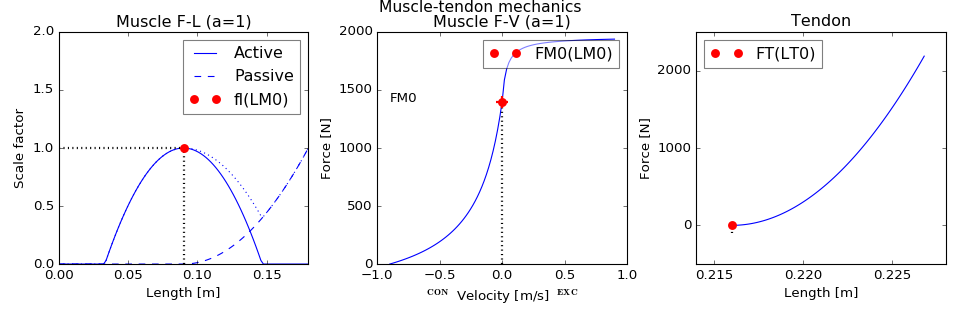

In [26]:
muscle_plot(a=1)

## Simulation - Parallel

In [27]:
#Normalizing
for i in range (len(t)):
    
    Lm =  totalMuscleLength(phi,A)
    
    # -----------------------------------------------------
    Lnorm_see = dorsiflexor.tendonLength(Lm,Lnorm_ce)

    Fnorm_tendon = dorsiflexor.TendonForce(Lnorm_see) 
    
    Fnorm_kpe = ParallelElementForce (Lnorm_ce)     
        
    #isometric force at Lce from CE force length relationship
    F0 = ForceLengthCurve (Lnorm_ce,width)
    
    Fnorm_CE = ContractileElementForce(Fnorm_tendon,Fnorm_kpe, alpha) #Fnorm_CE = ~Fm
    
    # -----------------------------------------------------
    
    #computing activation
    a = activation(a,u[i],h)
    
    #calculate CE velocity from Hill's equation    
    Lnorm_cedot = ContractileElementDot(F0, Fnorm_CE,a)
    
    #Compute MomentJoint
    Rf = momentArm(phi,B) #moment arm
    M = momentJoint(Rf,Fnorm_tendon,Fmax,mfoot,g,phi)
    
    #Compute Angular Aceleration Joint
    phidd = angularAcelerationJoint (M,Ifoot)
    
    # Euler integration steps
    Lnorm_ce = Lnorm_ce + h*Lnorm_cedot
    phid= phid + h*phidd
    phi  = phi  +h*phid

    # Store variables in vectors
    F[i] = Fnorm_tendon*Fmax
    Fkpe[i] = Fnorm_kpe*Fmax
    FiberLen[i] = Lnorm_ce*Lce_o
    TendonLen[i] = Lnorm_see*Lce_o
    a_dynamics[i] = a
    phi_dynamics[i] = phi
    fiberVelocity[i] = Lnorm_cedot*Lce_o
    #moment[i] = 

## Plots 

<IPython.core.display.Javascript object>


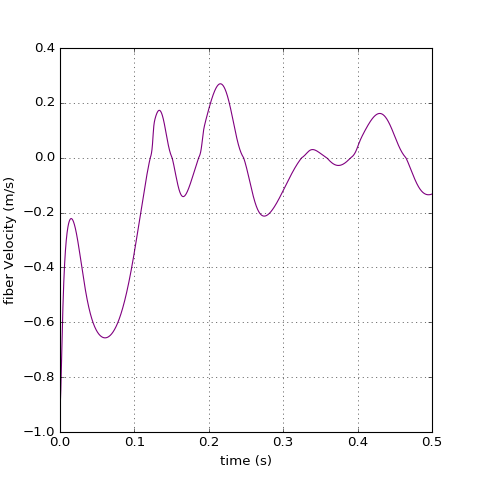

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,fiberVelocity,c='purple')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('fiber Velocity (m/s)')

<IPython.core.display.Javascript object>


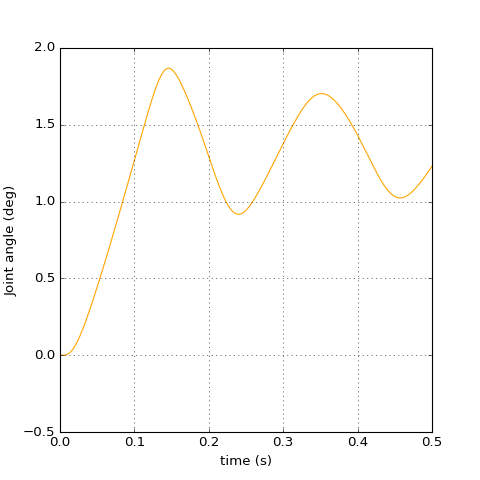

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,phi_dynamics ,c='orange')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Joint angle (deg)')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,a_dynamics,c='magenta')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Activation dynamics')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,F,c='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Force (N)')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,FiberLen, label = 'fiber')
ax.plot(t,TendonLen, label = 'tendon')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Length (m)')
ax.legend(loc='best')


fig, ax = plt.subplots(1, 3, figsize=(9,4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=.12, hspace=None,left=None, bottom=None, right=None, top=None,)
ax[0].plot(t,FiberLen, label = 'fiber')
ax[1].plot(t,TendonLen, label = 'tendon')
ax[2].plot(t,FiberLen + TendonLen, label = 'muscle (tendon + fiber)')

ax[1].set_xlabel('time (s)')
ax[0].set_ylabel('Length (m)')
#ax[i].legend(loc='best')